In [1]:
import numpy as np
import torch
from matplotlib import cm
import matplotlib.pyplot as plt

x = np.random.uniform(-1.0, 1.0, (200, 1))
y = x**2

x = torch.tensor(x, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

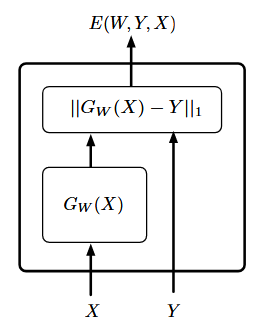

In [2]:
class Regressor(torch.nn.Module):
    def __init__(self, hidden_uts=20, *args, **kwargs):
        super().__init__(*args, **kwargs)
        # self.W1 = torch.nn.Parameter(torch.rand(1, hidden_uts)*1**-0.5)
        # self.W1 = torch.nn.Parameter(torch.rand(1, hidden_uts)*(hidden_uts/(hidden_uts+1))**0.5)
        self.W1 = torch.nn.Parameter(torch.rand(1, hidden_uts))
        self.b1 = torch.nn.Parameter(torch.zeros(hidden_uts,))

        # self.W2 = torch.nn.Parameter(torch.rand(hidden_uts, hidden_uts)*(2/(hidden_uts+hidden_uts))**0.5)
        self.W2 = torch.nn.Parameter(torch.rand(hidden_uts, hidden_uts))
        self.b2 = torch.nn.Parameter(torch.zeros(hidden_uts,))

        self.out_proj = torch.nn.Parameter(torch.rand(hidden_uts, 1)*(hidden_uts**-0.5))
        # self.out_proj = torch.nn.Parameter(torch.rand(hidden_uts, 1)*(2/(hidden_uts+1))**0.5)

        torch.nn.init.xavier_uniform_(self.W1)
        torch.nn.init.xavier_uniform_(self.W2)

    def forward(self, x, y):
        act = torch.nn.functional.tanh
        x = act(x @ self.W1 + self.b1)
        x = act(x @ self.W2 + self.b2)

        x = x @ self.out_proj
        return x, y

Energy function
$E(W,Y^i,X^i)= ||G_W(X^i)-Y^i||$

Loss function
* $\mathcal{S}$: Dataset of inputs and labels.
* $P$: Number of samples in the dataset. \
$L(W,\mathcal{S}) = \frac{1}{P}\sum_{i=1}^P E(W,Y^i,X^i)$

In [3]:
def energy_fn(model, x, y):
    pred_y, encod_y = model(x, y)

    if pred_y.shape[1] > 1:
        energy = torch.abs(pred_y - encod_y).sum(dim = -1)
    else:
        energy = torch.abs(pred_y - encod_y)
    return energy

def energyloss_fn(model, x, y, energy_fn):
    energies = energy_fn(model, x, y)

    return energies

def plot_surfacce(model, x, y, energy_fn, **kwargs):
    
    x_space = np.linspace(-1, 1, 100)
    y_space = np.linspace(-2,2, 200)
    x_space, y_space = np.meshgrid(x_space, y_space)

    x_ = torch.tensor(x_space, dtype=torch.float32, device=x.device).reshape(-1, 1)
    y_ = torch.tensor(y_space, dtype=torch.float32, device=y.device).reshape(-1, 1)
    z_space = energy_fn(model, x_, y_)
    z_space = z_space.reshape(x_space.shape).detach().cpu().numpy()

    fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
    surf = ax.plot_surface(x_space, y_space, z_space, cmap=cm.coolwarm,
                        linewidth=0, antialiased=False, alpha=0.7)
    
    real_labels_energy = energy_fn(model, x, y).detach().cpu().numpy()

    ax.scatter(x.cpu(), y.cpu(), real_labels_energy, s=50, color='green')
    ax.view_init(elev=kwargs.get('elev', 60), azim=kwargs.get('azim', 70))
    plt.show()

def training(model, loss_fn, x, y, energy_fn, epochs=100, lr = 0.1, batch_size = 8, chart_epochs=[1,10,60,100]):
    n = x.shape[0]

    optim = torch.optim.Adam(model.parameters(), lr=lr)

    for i in range(epochs):
        perm = torch.randperm(n, device=x.device)

        losses = []

        for start in range(0, n, batch_size):
            optim.zero_grad()
            
            idx = perm[start:start + batch_size]
            x_batch, y_batch = x[idx], y[idx]
            loss_val = loss_fn(model, x_batch, y_batch, energy_fn).mean()
            losses.append(loss_val.item())


            loss_val.backward()
            optim.step()
            # for p in model.parameters():
            #     if p.grad is not None:
            #         p.data -= lr * p.grad
            #         p.grad.zero_()

        avg_loss = sum(losses)/len(losses)

        if (i+1)%10 == 0 or i == 0 or i == epochs-1:
            print(f"Loss step {i+1:>5}: {avg_loss:>10,.4f}")

        if (i+1) in chart_epochs:
            plot_surfacce(model, x, y, energy_fn)

Loss step     1:     0.2828


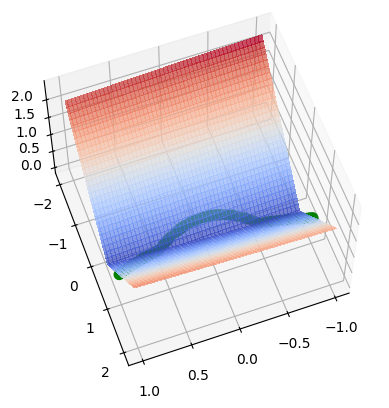

Loss step    10:     0.2666


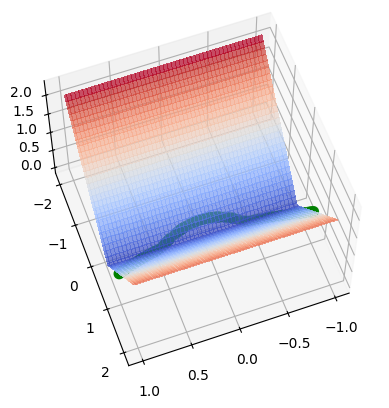

Loss step    20:     0.2679
Loss step    30:     0.2629
Loss step    40:     0.2649
Loss step    50:     0.2654
Loss step    60:     0.1398


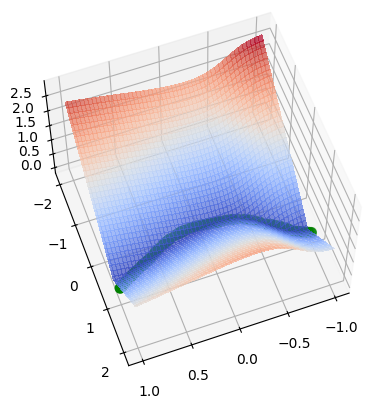

Loss step    70:     0.0718
Loss step    80:     0.0717
Loss step    90:     0.0309
Loss step   100:     0.0245


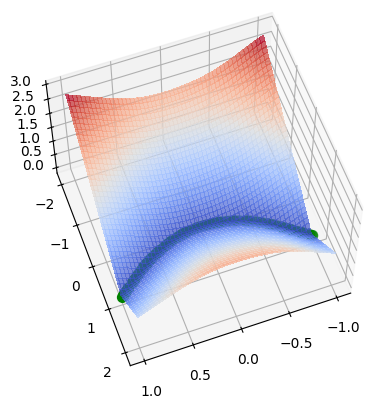

In [4]:
regressor = Regressor()

training(regressor, energyloss_fn, x, y, energy_fn, lr=0.01, epochs = 100, batch_size=4)

## Second architecture

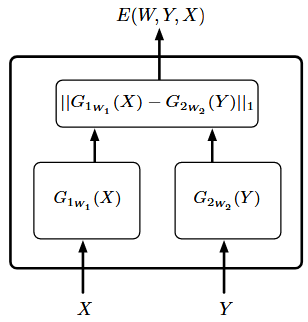

In [14]:
class JEA(torch.nn.Module):
    def __init__(self, hidden_uts=10, out_units=10, *args, **kwargs):
        super().__init__(*args, **kwargs)
        # encode x
        self.xW1 = torch.nn.Parameter(torch.rand(1, hidden_uts))
        self.xb1 = torch.nn.Parameter(torch.zeros(hidden_uts,))

        self.xW2 = torch.nn.Parameter(torch.rand(hidden_uts, hidden_uts))
        self.xb2 = torch.nn.Parameter(torch.zeros(hidden_uts,))

        self.xout_proj = torch.nn.Parameter(torch.rand(hidden_uts, out_units)*(hidden_uts**-0.5))

        torch.nn.init.xavier_uniform_(self.xW1)
        torch.nn.init.xavier_uniform_(self.xW2)

        # encode y
        self.yW1 = torch.nn.Parameter(torch.rand(1, hidden_uts))
        self.yb1 = torch.nn.Parameter(torch.zeros(hidden_uts,))

        self.yW2 = torch.nn.Parameter(torch.rand(hidden_uts, hidden_uts))
        self.yb2 = torch.nn.Parameter(torch.zeros(hidden_uts,))

        self.yout_proj = torch.nn.Parameter(torch.rand(hidden_uts, out_units)*(hidden_uts**-0.5))

        torch.nn.init.xavier_uniform_(self.yW1)
        torch.nn.init.xavier_uniform_(self.yW2)
        

    def forward(self, x, y):
        act = torch.nn.functional.tanh
        x = act(x @ self.xW1 + self.xb1)
        x = act(x @ self.xW2 + self.xb2)
        x = x @ self.xout_proj

        y = act(y @ self.yW1 + self.yb1)
        y = act(y @ self.yW2 + self.yb2)
        y = y @ self.yout_proj
        return x, y

Energy function
$E(W,Y^i,X^i)= ||G_{W_1}(X^i)-G_{W_2}(Y^i)||$

Loss function
* $\mathcal{S}$: Dataset of inputs and labels.
* $P$: Number of samples in the dataset. \
$L(W,\mathcal{S}) = \frac{1}{P}\sum_{i=1}^P E(W,Y^i,X^i)$

Loss step     1:     0.1953


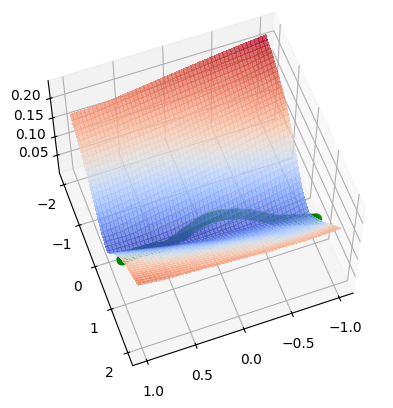

Loss step    10:     0.0104


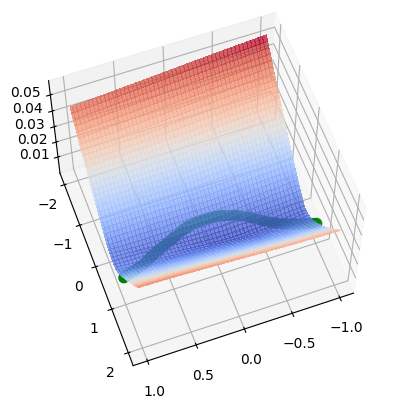

Loss step    20:     0.0014
Loss step    30:     0.0001
Loss step    40:     0.0000
Loss step    50:     0.0000
Loss step    60:     0.0019


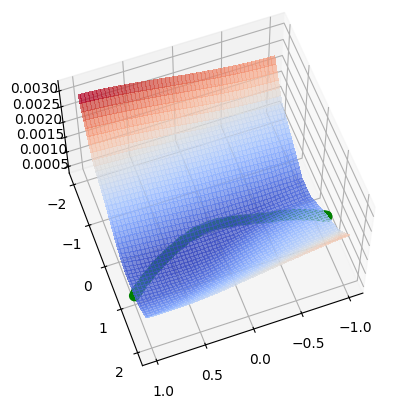

Loss step    70:     0.0000
Loss step    80:     0.0043
Loss step    90:     0.0001
Loss step   100:     0.0032


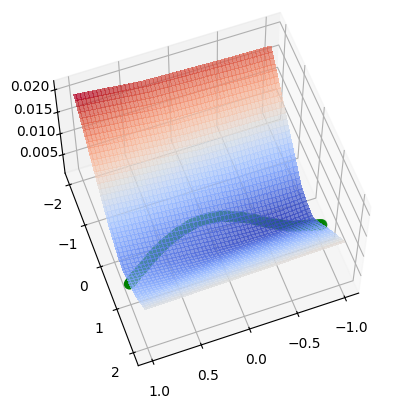

In [15]:
model = JEA()

training(model, energyloss_fn, x, y, energy_fn, lr=0.01, epochs = 100, batch_size=4)

## Using a better energy function for more complex archs

Energy function
$E(W,Y^i,X^i)= ||G_{W_1}(X^i)-G_{W_2}(Y^i)||$

Loss function
* $\mathcal{S}$: Dataset of inputs and labels.
* $P$: Number of samples in the dataset.
* $m$: Margin.
* $\bar{Y}^i$: the most offending incorrect answer is the answer that has the lowest energy among all answers that are at least $\epsilon$ away from the correct answer. \
$L_{\text{sq-sq}}(W,\mathcal{S}) = \frac{1}{P}\sum_{i=1}^P E(W,Y^i,X^i)^2 - (\max(0, m - E(W,\bar{Y}^i, X^i)))^2$

In [5]:
def find_the_most_effending_answers(model, x, y, epsilon=0.01, steps=200, lr=0.001, log=False, shift_answers=True):
    for p in model.parameters():
        p.requires_grad = False

    optim_y = torch.rand(y.shape, device=y.device)
    # optim_y = (optim_y - 0.5)*2 # Unif(-2,2). It works even though negative values are not part of the y domain
    optim_y.requires_grad = True

    for step in range(steps):
        loss = energy_fn(model, x, optim_y)
        if log:
            print(f"loss step {step+1:>4}: {loss.mean().item():>7,.4f}")
        init_grad = torch.ones_like(loss, device=loss.device)
        loss.backward(init_grad)

        optim_y.data -= lr * optim_y.grad

        optim_y.grad.zero_()

    for p in model.parameters():
        p.requires_grad = True
    
    optim_y.requires_grad = False

    if shift_answers:
        # Add an epsilon if the minimum is not at least epsilon from the correct answer
        epsilon = (torch.abs(optim_y - y)-epsilon).clip(None, 0)
        # Shift the offending value towards the opposite of the correct answer
        epsilon *= torch.where(optim_y - y >= 0, -1.0, 1.0) # the signs are inverted since epsilon is negative
        optim_y += epsilon
    return optim_y

### Optimizing through the energy landscape gives a similar result that using the regressor directly\

The avg. absolute difference between the regressor answers and the real answers:

In [6]:
optim_y_regressor, _ = regressor(x, y)
torch.abs(optim_y_regressor - y).mean()

tensor(0.0186, grad_fn=<MeanBackward0>)

The avg. absolute difference between the answers produced by optimization and the real answers:

In [9]:
optim_y = find_the_most_effending_answers(regressor, x, y, steps=100, lr=0.01, log=True, shift_answers=False)

loss step    1:  0.3466
loss step    2:  0.3369
loss step    3:  0.3276
loss step    4:  0.3185
loss step    5:  0.3098
loss step    6:  0.3010
loss step    7:  0.2924
loss step    8:  0.2838
loss step    9:  0.2755
loss step   10:  0.2673
loss step   11:  0.2596
loss step   12:  0.2518
loss step   13:  0.2444
loss step   14:  0.2370
loss step   15:  0.2301
loss step   16:  0.2231
loss step   17:  0.2167
loss step   18:  0.2103
loss step   19:  0.2042
loss step   20:  0.1981
loss step   21:  0.1924
loss step   22:  0.1868
loss step   23:  0.1814
loss step   24:  0.1761
loss step   25:  0.1708
loss step   26:  0.1656
loss step   27:  0.1605
loss step   28:  0.1555
loss step   29:  0.1509
loss step   30:  0.1461
loss step   31:  0.1415
loss step   32:  0.1370
loss step   33:  0.1326
loss step   34:  0.1282
loss step   35:  0.1240
loss step   36:  0.1197
loss step   37:  0.1157
loss step   38:  0.1115
loss step   39:  0.1077
loss step   40:  0.1036
loss step   41:  0.1001
loss step   42: 

In [10]:
torch.abs(optim_y - y).mean()

tensor(0.0184)

First sample comparison

In [11]:
print(f"Regressor answer: {optim_y_regressor[0].item():.4f}, Optimized answer: {optim_y[0].item():.4f}, Real answer: {y[0].item():.4f}")

Regressor answer: 0.1146, Optimized answer: 0.1097, Real answer: 0.1248


### Using the Square-Square loss to train the energy model

In [12]:
def sqsqloss_fn(model, x, y, energy_fn, m=0.1, intra_steps=100, epsilon=0.1):
    energies = energy_fn(model, x, y)

    # off_y = y + m
    # off_energies = energy_fn(model, x, off_y)
    # off_y = y - m
    # off_energies2 = energy_fn(model, x, off_y)
    # off_energies = torch.min(off_energies, off_energies2)

    # with torch.no_grad():
    #     optim_y, _ = model(x, y)
    # # Add an epsilon if the minimum is not at least epsilon from the correct answer
    # epsilon = (torch.abs(optim_y - y)-epsilon).clip(None, 0)
    # # Shift the offending value towards the opposite of the correct answer
    # epsilon *= torch.where(optim_y - y >= 0, -1.0, 1.0) # the signs are inverted since epsilon is negative
    # off_y = optim_y

    # Optim method
    off_y = find_the_most_effending_answers(model, x, y, lr=0.02, steps=intra_steps, epsilon=epsilon)
    
    off_energies = energy_fn(model, x, off_y)

    loss = energies**2 + (torch.clip(m - off_energies, 0, None))**2

    return loss

Loss step     1:     0.2683


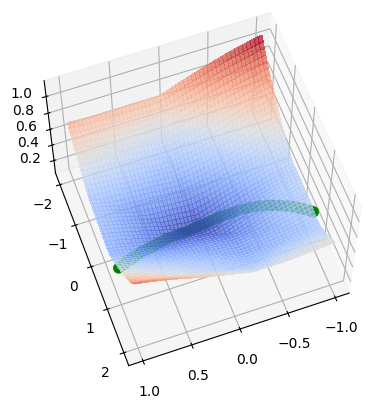

Loss step    10:     0.1154


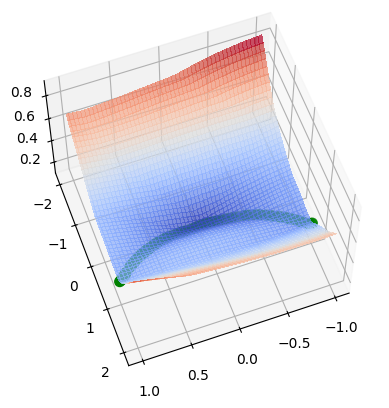

Loss step    20:     0.1135
Loss step    30:     0.1111
Loss step    40:     0.1150
Loss step    50:     0.1149
Loss step    60:     0.1190


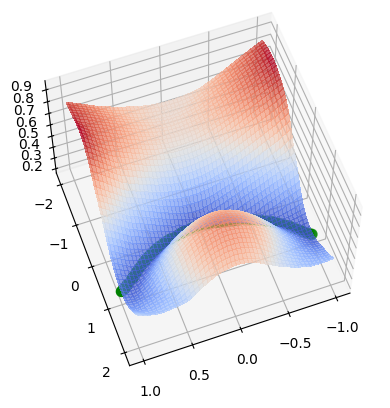

Loss step    70:     0.1209
Loss step    80:     0.1202
Loss step    90:     0.1234
Loss step   100:     0.1227


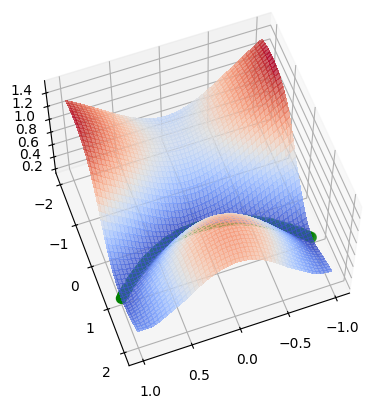

In [16]:
model = JEA()

sqsqloss_fn_m = lambda model, x, y, energy_fn: sqsqloss_fn(model, x, y, energy_fn, 0.5, intra_steps=50, epsilon=0.01)

training(model.cuda(), sqsqloss_fn_m, x.cuda(), y.cuda(), energy_fn, lr=0.001, epochs = 100, batch_size=8)

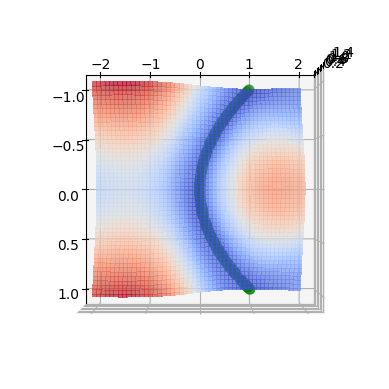

In [17]:
plot_surfacce(model, x.cuda(), y.cuda(), energy_fn, azim=-0, elev=90)

In [22]:
optim_y = find_the_most_effending_answers(model, x.cuda(), y.cuda(), steps=300, lr=0.01, log=True, shift_answers=False)

loss step    1:  0.4658
loss step    2:  0.4611
loss step    3:  0.4564
loss step    4:  0.4517
loss step    5:  0.4471
loss step    6:  0.4425
loss step    7:  0.4380
loss step    8:  0.4336
loss step    9:  0.4292
loss step   10:  0.4249
loss step   11:  0.4206
loss step   12:  0.4164
loss step   13:  0.4123
loss step   14:  0.4082
loss step   15:  0.4042
loss step   16:  0.4003
loss step   17:  0.3965
loss step   18:  0.3927
loss step   19:  0.3890
loss step   20:  0.3853
loss step   21:  0.3816
loss step   22:  0.3779
loss step   23:  0.3744
loss step   24:  0.3708
loss step   25:  0.3673
loss step   26:  0.3638
loss step   27:  0.3604
loss step   28:  0.3571
loss step   29:  0.3539
loss step   30:  0.3507
loss step   31:  0.3476
loss step   32:  0.3445
loss step   33:  0.3415
loss step   34:  0.3385
loss step   35:  0.3355
loss step   36:  0.3326
loss step   37:  0.3299
loss step   38:  0.3271
loss step   39:  0.3244
loss step   40:  0.3218
loss step   41:  0.3193
loss step   42: 

In [23]:
torch.abs(optim_y - y.cuda()).mean()

tensor(0.0332, device='cuda:0')

### Negative log-likelihood loss

Energy function
$E(W,Y^i,X^i)= ||G_{W_1}(X^i)-G_{W_2}(Y^i)||$

Loss function
* $\mathcal{S}$: Dataset of inputs and labels.
* $P$: Number of samples in the dataset.
* $\beta$: Opposite of temperature \
$L_{\text{nll}}(W,\mathcal{S}) = \frac{1}{P}\sum_{i=1}^P E(W,Y^i,X^i) + \frac{1}{\beta}\log(\int_{y\in\mathcal{Y}} e^{-\beta E(W,y,X^i)})$

In [24]:
def nll_loss_fn(model, x, y, energy_fn, beta=1):
    energies = energy_fn(model, x, y)

    # for each x generate 100 samples of energy
    n_samples = 100
    up_lim = 2
    low_lim = -2
    y_samples = torch.linspace(low_lim,up_lim,n_samples).reshape(1, -1)
    y_samples = y_samples + y
    sample_shape = y_samples.shape
    x_samples = x.repeat(n_samples, 1)
    samples_energy = energy_fn(model, x_samples, y_samples.reshape(-1, 1))
    samples_energy = samples_energy.reshape(sample_shape)
    
    integral = -beta* samples_energy
    integral = (integral.exp() * (up_lim-low_lim)/n_samples).sum(dim=1)

    loss = energies + (1/beta)*torch.log(integral)
    return loss

Loss step     1:     0.6024


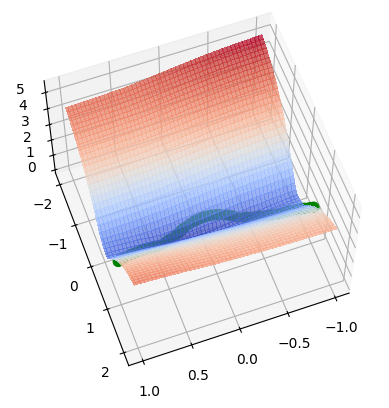

Loss step    10:    -0.0413


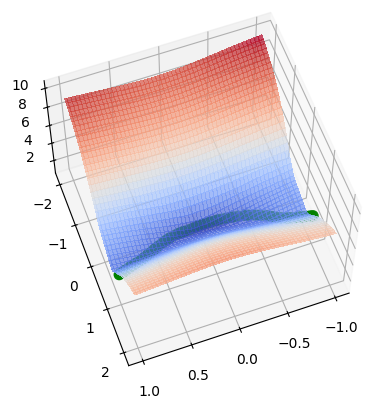

Loss step    20:    -0.6033
Loss step    30:    -1.1082
Loss step    40:    -1.5574
Loss step    50:    -1.7251
Loss step    60:    -1.8668


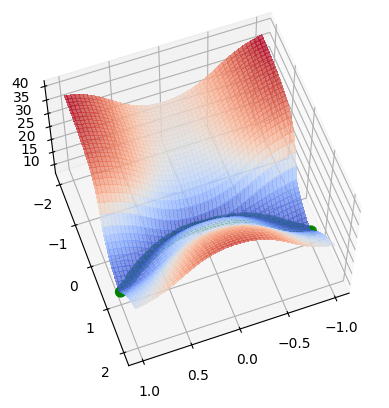

Loss step    70:    -1.9717
Loss step    80:    -2.0886
Loss step    90:    -2.1661
Loss step   100:    -2.2420


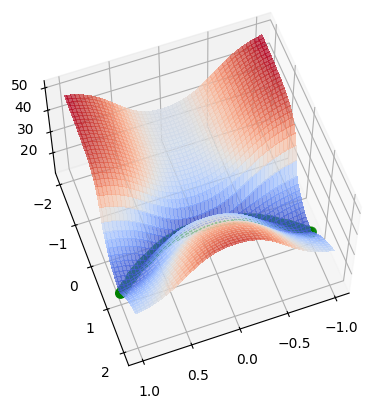

In [25]:
model = JEA()

nll_loss_fn_b = lambda model, x, y, energy_fn: nll_loss_fn(model, x, y, energy_fn, 1)

training(model, nll_loss_fn_b, x, y, energy_fn, lr=0.001, epochs = 100, batch_size=6)

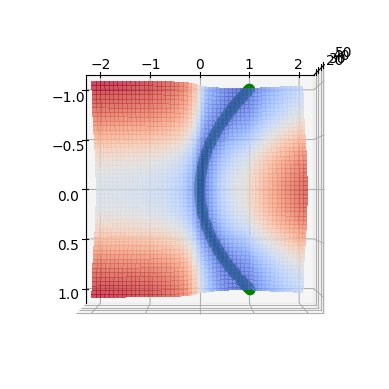

In [26]:
plot_surfacce(model, x, y, energy_fn, azim=-0, elev=90)

In [27]:
optim_y = find_the_most_effending_answers(regressor, x, y, steps=100, lr=0.01, log=True, shift_answers=False)

loss step    1:  0.3495
loss step    2:  0.3397
loss step    3:  0.3301
loss step    4:  0.3204
loss step    5:  0.3110
loss step    6:  0.3016
loss step    7:  0.2926
loss step    8:  0.2835
loss step    9:  0.2747
loss step   10:  0.2659
loss step   11:  0.2573
loss step   12:  0.2489
loss step   13:  0.2409
loss step   14:  0.2332
loss step   15:  0.2257
loss step   16:  0.2182
loss step   17:  0.2110
loss step   18:  0.2040
loss step   19:  0.1974
loss step   20:  0.1909
loss step   21:  0.1849
loss step   22:  0.1787
loss step   23:  0.1730
loss step   24:  0.1670
loss step   25:  0.1617
loss step   26:  0.1562
loss step   27:  0.1510
loss step   28:  0.1457
loss step   29:  0.1409
loss step   30:  0.1358
loss step   31:  0.1312
loss step   32:  0.1264
loss step   33:  0.1222
loss step   34:  0.1175
loss step   35:  0.1133
loss step   36:  0.1088
loss step   37:  0.1048
loss step   38:  0.1003
loss step   39:  0.0964
loss step   40:  0.0923
loss step   41:  0.0886
loss step   42: 

In [28]:
torch.abs(optim_y - y).mean()

tensor(0.0185)